In [17]:
import gymnasium as gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt

### UAV Environment

In [18]:
class UAV_Environment(gym.Env):

    def __init__(self, users = 250, uavs = 3, size = 2000, 
                v_0 = 5, # (m/s)
                ###################### Channel model of UAVS
                psi_L = 1,
                psi_M = 1,
                K = 50, 
                d = 1, # (m)
                lambda_c = 0.1, # (m)
                h = 120, # (m)
                alpha = 2.7,
                P_UAV = 30, # (dBm)
                sigma_square = 90,  
                ###################### Channel model of mBS
                P_mBS = 46, # (dBm)
                D_hb = 10, # (m)
                f_c = 2e3, # GHz -> (MHz)
                sigma_logF = 2,
                ###################### Bandwidth
                W = 20e6, # MHz -> (Hz)
                ###################### Data Rate Threshold
                r_th = 20e6,
                ): 


        self.users = users
        self.uavs = uavs
        self.size = size
        self.v_o = v_0
        self.psi_L = psi_L
        self.psi_M = psi_M
        self.K = K
        self.d = d
        self.lambda_c = lambda_c
        self.h = h
        self.alpha = alpha
        self.P_UAV = P_UAV
        self.sigma_square = sigma_square
        self.P_mBS = P_mBS
        self.D_hb = D_hb
        self.f_c = f_c
        self.sigma_logF = sigma_logF
        self.W = W
        self.r_th = r_th

        self.connect = np.zeros((self.uavs+1, self.users))
        self.unsatisfied_users = np.zeros(self.users)

        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self.uavs_location = np.zeros((2, self.uavs)) + self.size/2
        self.users_location = np.random.uniform(-self.size/2, self.size/2, (2, self.users))
        self.mBS = np.zeros((2,1)) + self.size/2
        
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        # self.observation_space = gym.spaces.Dict(
        #     {
        #         "agent": gym.spaces.Box(-size/2, size/2, shape=(2,uavs), dtype=float),
        #     }
        # )

        self.observation_space = gym.spaces.Box(-self.size/2, self.size/2, shape=(2,uavs), dtype=float),


        # We have 5 actions, corresponding to "right", "up", "left", "down", "remain stationary"
        self.action_space = gym.spaces.Discrete(5)
        # Dictionary maps the abstract actions to the directions
        self._action_to_direction = {
            0: np.array([v_0, 0]),  # right
            1: np.array([0, v_0]),  # up
            2: np.array([-v_0, 0]),  # left
            3: np.array([0, -v_0]),  # down
            4: np.array([0, 0]),  # remain stationary
        }
    def step(self, actions):
        
        ## UAVs take the actions
        for action,k in zip(actions,range(self.uavs)):
            tem = self.uavs_location[:,k] + self._action_to_direction[action]
            if (-self.size/2 > tem[0] or tem[0] > self.size/2) or (-self.size/2 > tem[1] or tem[1] > self.size/2): # restrict the UAVs' coordinates
                continue
            self.uavs_location[:,k] = tem

        ## Distance
        d_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                d_UAV[k,n] = np.linalg.norm(self.users_location[:,n] - self.uavs_location[:,k], ord = 2)

        d_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            d_mBS[0,n] = np.linalg.norm(self.users_location[:,n] - self.mBS[:,0], ord = 2)

        ## Signal-to-noise ratio(SNR)
        gamma_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                psi_UAV = math.sqrt(self.K/(1+self.K))*self.psi_L + math.sqrt(1/(1+self.K))*self.psi_M
                theta = -20*math.log10(4*3.14*self.d/self.lambda_c)
                g_UAV = (abs(psi_UAV)**2)*theta*(math.sqrt(d_UAV[k,n]**2 + self.h**2)/self.d)**(-self.alpha)
                gamma_UAV[k,n] = self.P_UAV*g_UAV/self.sigma_square

        gamma_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            LogF = random.gauss(0, self.sigma_logF)
            L_mBS = 40*(1-0.004*self.D_hb)*math.log10(d_mBS[0,n]/1000) - 18*math.log10(self.D_hb) + 21*math.log10(self.f_c) # + 80 # d_mBS (km) ; D_hb (m); fc (MHz)
            gamma_mBS[0,n] = self.P_mBS - L_mBS - LogF

        ## Data rate
        rate_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                gamma_UAV[k,n] = 10**(gamma_UAV[k,n]/10)
                rate_UAV[k,n] = self.W*math.log2(1 + gamma_UAV[k,n])
                    
        rate_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            gamma_mBS[0,n] = 10**(gamma_mBS[0,n]/10)
            rate_mBS[0,n] = self.W*math.log2(1 + gamma_mBS[0,n])
            

        ##### connect =
        #####    [ ------------ UAV1 -----------] 
        #####    [ ------------ UAV2 -----------]
        #####    [ ------------ UAV3 -----------]
        #####    [ ------------ mBS  -----------]
        
        # print('UAV data rate: ', rate_UAV,'\n mBS data rate: ' ,rate_mBS)
        rate_UAV_mBS = np.concatenate((rate_UAV, rate_mBS), axis=0) # Shape(4,150) -> 3 UAVs + 1 mBS ; 150 Users
        data_rate_max_index = np.argmax(rate_UAV_mBS, axis=0)
        for index,user in zip(data_rate_max_index,range(self.users)):
            self.connect[index,user] = 1

        data_rate = np.multiply(rate_UAV_mBS,self.connect)
        data_rate = np.sum(data_rate,axis=0)

        # S_t (satisfied users)
        S = 0
        for r_n in data_rate.tolist():
            if r_n > self.r_th:
                S = S + 1
        # print('S=', S)

        # unsatisfied users

        for i in range(data_rate.shape[0]):
            if data_rate[i] < self.r_th:
                self.unsatisfied_users[i] = 0
            else:
                self.unsatisfied_users[i] = 1

        N_UAVs = np.sum(self.connect, axis=1)
        N_UAV0 = N_UAVs[0]
        # print('N_UAV0=',N_UAV0)
        N_UAV1 = N_UAVs[1]
        # print('N_UAV1=',N_UAV1)
        N_UAV2 = N_UAVs[2]
        # print('N_UAV2=',N_UAV2)

        O_UAV0 = np.concatenate((self.uavs_location[:,0], self.mBS[:,0],self.uavs_location[:,1],self.uavs_location[:,2],self.connect[0,:],self.unsatisfied_users))
        # print('O_UAV0=',O_UAV0.shape)
        O_UAV1 = np.concatenate((self.uavs_location[:,1], self.mBS[:,0],self.uavs_location[:,0],self.uavs_location[:,2],self.connect[1,:],self.unsatisfied_users))
        # print('O_UAV1=',O_UAV1.shape)
        O_UAV2 = np.concatenate((self.uavs_location[:,2], self.mBS[:,0],self.uavs_location[:,0],self.uavs_location[:,1],self.connect[2,:],self.unsatisfied_users))
        # print('O_UAV2=',O_UAV2.shape)
        
        
        return O_UAV0, O_UAV1, O_UAV2, S, N_UAV0, N_UAV1, N_UAV2

    def plot(self):
        plt.scatter(self.users_location[0,:],self.users_location[1,:], label = 'USER')
        plt.scatter(self.uavs_location[0,0],self.uavs_location[1,0], label = 'UAV0')
        plt.scatter(self.uavs_location[0,1],self.uavs_location[1,1], label = 'UAV1')
        plt.scatter(self.uavs_location[0,2],self.uavs_location[1,2], label = 'UAV2')
        plt.scatter(self.mBS[0],self.mBS[1], label = 'mBS')
        plt.xlabel('x(m)')
        plt.ylabel('y(m)')
        plt.title('UAV Environment')
        plt.legend()
        plt.show()

    def reset(self):
        self.uavs_location = np.zeros((2, self.uavs)) + self.size/2
        self.connect = np.zeros((self.uavs+1, self.users))
        self.unsatisfied_users = np.zeros(self.users)
        O_UAV0 = np.concatenate((self.uavs_location[:,0], self.mBS[:,0],self.uavs_location[:,1],self.uavs_location[:,2],self.connect[0,:],self.unsatisfied_users))
        # print('O_UAV0=',O_UAV0.shape)
        O_UAV1 = np.concatenate((self.uavs_location[:,1], self.mBS[:,0],self.uavs_location[:,0],self.uavs_location[:,2],self.connect[1,:],self.unsatisfied_users))
        # print('O_UAV1=',O_UAV1.shape)
        O_UAV2 = np.concatenate((self.uavs_location[:,2], self.mBS[:,0],self.uavs_location[:,0],self.uavs_location[:,1],self.connect[2,:],self.unsatisfied_users))
        # print('O_UAV2=',O_UAV2.shape)
        
        return O_UAV0, O_UAV1, O_UAV2      
            

In [19]:
env = UAV_Environment()

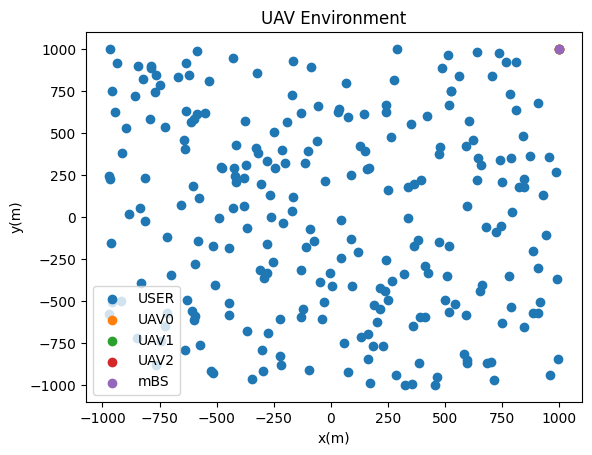

In [20]:
env.plot()

In [21]:
state = env.reset()
for _ in range(100):
    actions = []
    for i in range(4):
        actions.append(env.action_space.sample())
    O_UAV0, O_UAV1, O_UAV2, S, N_UAV0, N_UAV1, N_UAV2 = env.step(actions)

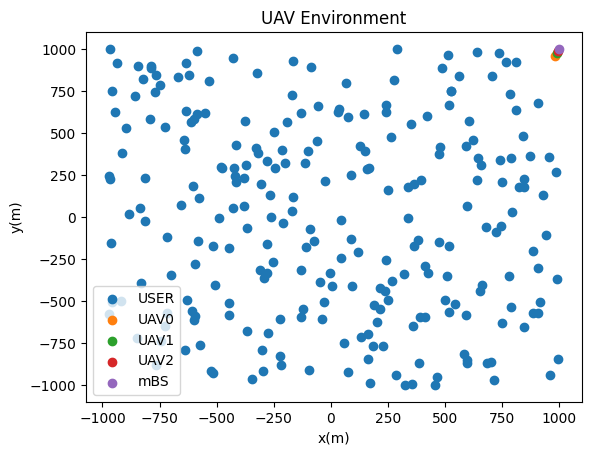

In [22]:
env.plot()

### Multi-agent Deep Reinforcement Learning

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque

In [24]:
# Hyperparameter
h_size = 128
lr = 0.0001
n_training_episodes = 5000
max_steps = 500
gamma = 0.99

In [25]:
# Policy Network
class Policy(nn.Module):
    def __init__(self , s_size , a_size , h_size ):
        super (Policy , self ).__init__ ()
        self.fc1 = nn.Linear( s_size , h_size )
        self.fc2 = nn.Linear( h_size , h_size * 2)
        self.fc3 = nn.Linear( h_size * 2, a_size )
    def forward(self , x):
        x = F.relu(self.fc1(x), inplace=True)
        x = F.relu(self.fc2(x), inplace=True)
        x = self.fc3(x)
        return F.softmax(x, dim =1)
    def act(self, state ):
        state = torch.from_numpy(state).float().unsqueeze(0)  #.to(device)
        probs = self.forward(state) # .cpu()
        m = Categorical(probs)
        # Random action
        action = m.sample()
        return action.item() , m.log_prob(action)

In [26]:
policy0 = Policy (
        s_size = 508 ,
        a_size = 5 ,
        h_size = h_size ,
        ) #.to(device)
optimizer0 = optim.Adam( policy0.parameters() , lr=lr)

policy1 = Policy (
        s_size = 508 ,
        a_size = 5 ,
        h_size = h_size ,
        ) #.to(device)
optimizer1 = optim.Adam( policy1.parameters() , lr=lr)

policy2 = Policy (
        s_size = 508 ,
        a_size = 5 ,
        h_size = h_size ,
        ) #.to(device)
optimizer2 = optim.Adam( policy2.parameters() , lr=lr)

optimizer = optim.Adam( list(policy0.parameters())+list(policy1.parameters())+list(policy2.parameters()), lr=lr)

In [27]:
# Training Function
def reinforce(
        policy0 ,
        optimizer ,
        # optimizer0 ,
        policy1 ,
        # optimizer1 ,
        policy2 ,
        # optimizer2 ,
        n_training_episodes ,
        max_steps ,
        gamma ,
        print_every
        ):
    # scores_deque = deque(maxlen =100)
    scores = []

    # Each Episode
    for i_episode in range(1, n_training_episodes + 1):
        print('Episode ',i_episode, '==================')
        saved_log_probs0 = []
        rewards0 = []
        saved_log_probs1 = []
        rewards1 = []
        saved_log_probs2 = []
        rewards2 = []
        O_UAV0, O_UAV1, O_UAV2 = env.reset()
        S, N_UAV0, N_UAV1, N_UAV2 = 0,0,0,0
        
        S_t, N_UAV0_t, N_UAV1_t, N_UAV2_t = 0,0,0,0
        g_t = 0
        l_t_0 = 0
        l_t_1 = 0
        l_t_2 = 0
        w = 0.1

        # t=1, 2, … , T (compute log(policy(a_t|s_t)))
        for t in range(max_steps):
            ## Take actions by policies
            action0 , log_prob_0 = policy0.act(O_UAV0)
            saved_log_probs0.append(log_prob_0)
            action1 , log_prob_1 = policy1.act(O_UAV1)
            saved_log_probs1.append(log_prob_1)
            action2 , log_prob_2 = policy0.act(O_UAV2)
            saved_log_probs2.append(log_prob_2)

            O_UAV0, O_UAV1, O_UAV2, S, N_UAV0, N_UAV1, N_UAV2 = env.step([action0, action1, action2])

            if S > S_t:
                g_t = 1
            elif S < S_t:
                g_t = -1
            else:
                g_t = 0

            if N_UAV0 > N_UAV0_t:
                l_t_0 = 1
            elif N_UAV0 < N_UAV0_t:
                l_t_0 = -1
            else:
                l_t_0 = 0

            if N_UAV1 > N_UAV1_t:
                l_t_1 = 1
            elif N_UAV1 < N_UAV1_t:
                l_t_1 = -1
            else:
                l_t_1 = 0

            if N_UAV2 > N_UAV2_t:
                l_t_2 = 1
            elif N_UAV2 < N_UAV2_t:
                l_t_2 = -1
            else:
                l_t_2 = 0

            S_t, N_UAV0_t, N_UAV1_t, N_UAV2_t = S, N_UAV0, N_UAV1, N_UAV2
                

            reward0 = w*l_t_0 + (1-w)*g_t
            rewards0.append(reward0)
            reward1 = w*l_t_1 + (1-w)*g_t
            rewards1.append(reward1)
            reward2 = w*l_t_2 + (1-w)*g_t
            rewards2.append(reward2)
            
            # if done :
            #     break
            
        # scores_deque.append(sum( rewards ))
        scores.append(sum(rewards0)+sum(rewards1)+sum(rewards2))

        returns0 = deque(maxlen = max_steps)
        returns1 = deque(maxlen = max_steps)
        returns2 = deque(maxlen = max_steps)
        
        n_steps = len(rewards0)

        # List of discounted Returns (compute gamma^t*G_t)
        for t in range(n_steps)[:: -1]:
            disc_return_t = returns0[0] if len(returns0) > 0 else 0
            returns0.appendleft(gamma*disc_return_t + rewards0[t])

        for t in range(n_steps)[:: -1]:
            disc_return_t = returns1[0] if len(returns1) > 0 else 0
            returns1.appendleft(gamma*disc_return_t + rewards1[t])

        for t in range(n_steps)[:: -1]:
            disc_return_t = returns2[0] if len(returns2) > 0 else 0
            returns2.appendleft(gamma*disc_return_t + rewards2[t])

        # Total loss (disc_return = gamma^t*G_t; log_prob = log(policy(a_t|s_t)))
        policy_loss0 = []
        for log_prob , disc_return in zip( saved_log_probs0 , returns0 ):
            policy_loss0.append(-log_prob * disc_return )
        policy_loss0 = torch.cat( policy_loss0 ).sum()

        policy_loss1 = []
        for log_prob , disc_return in zip( saved_log_probs1 , returns1 ):
            policy_loss1.append(-log_prob * disc_return )
        policy_loss1 = torch.cat( policy_loss1 ).sum()

        policy_loss2 = []
        for log_prob , disc_return in zip( saved_log_probs2 , returns2 ):
            policy_loss2.append(-log_prob * disc_return )
        policy_loss2 = torch.cat( policy_loss2 ).sum()


        total_loss = policy_loss0 + policy_loss1 + policy_loss2
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # optimizer0.zero_grad()
        # policy_loss0.backward()
        # optimizer0.step()
        # optimizer0.zero_grad()

        print(" Episode {}, The number of satisfied users : {} ".format(i_episode , S_t))
        env.plot()

    return scores

Episode  1 ==================
 Episode 1, The number of satisfied users : 250 


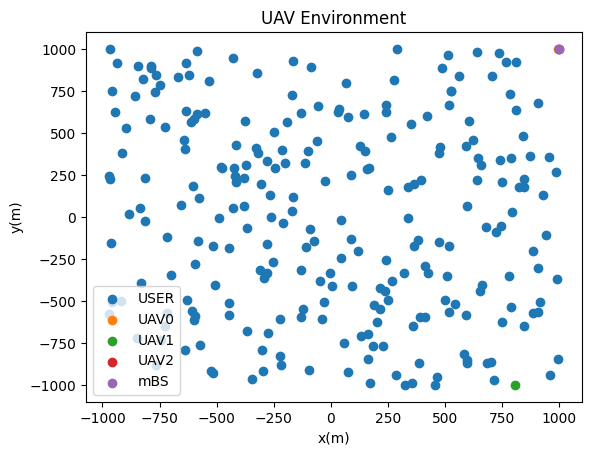

Episode  2 ==================
 Episode 2, The number of satisfied users : 250 


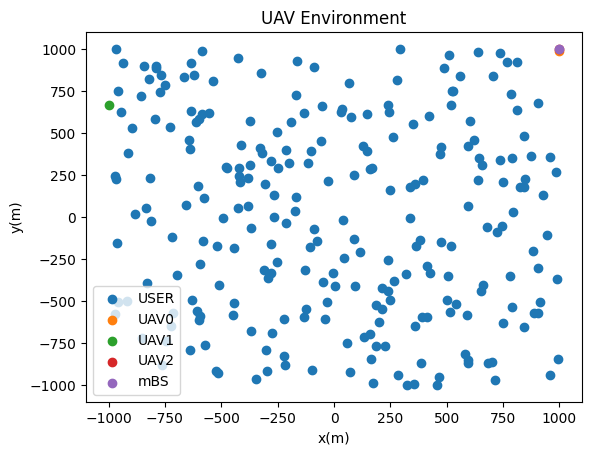

Episode  3 ==================
 Episode 3, The number of satisfied users : 111 


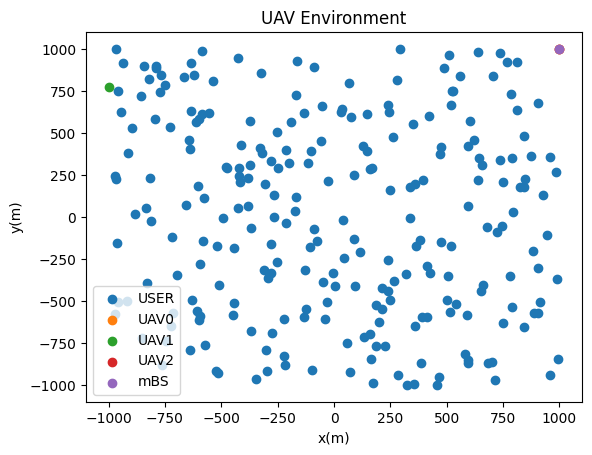

Episode  4 ==================
 Episode 4, The number of satisfied users : 123 


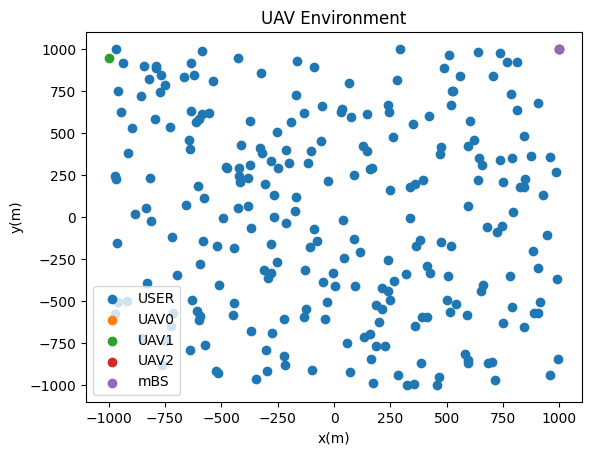

Episode  5 ==================
 Episode 5, The number of satisfied users : 123 


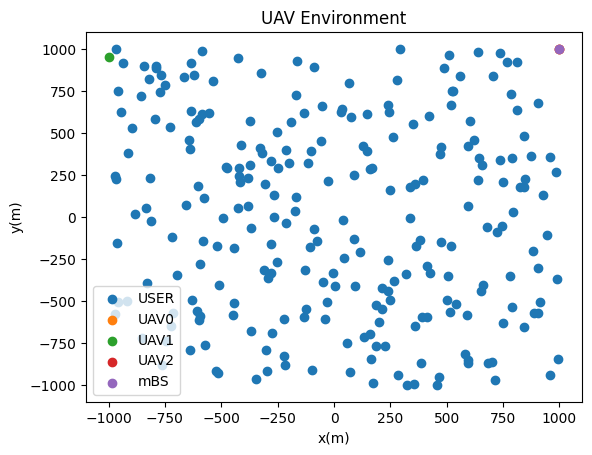

Episode  6 ==================
 Episode 6, The number of satisfied users : 123 


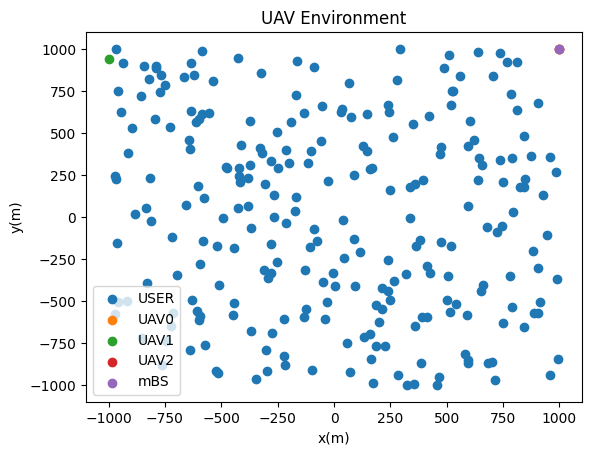

Episode  7 ==================
 Episode 7, The number of satisfied users : 123 


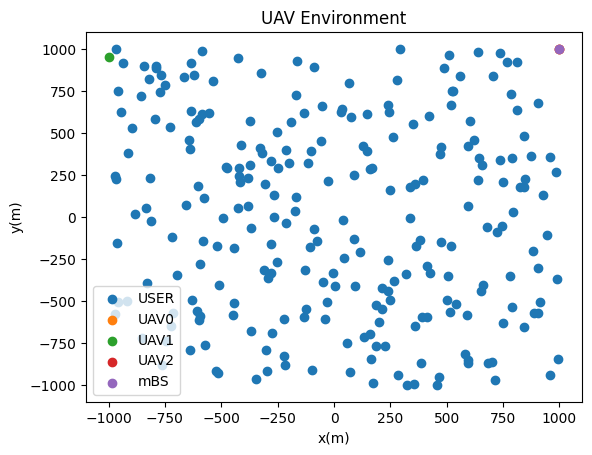

Episode  8 ==================
 Episode 8, The number of satisfied users : 123 


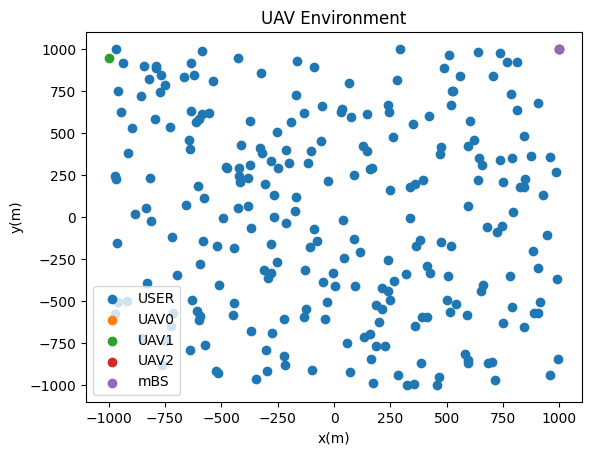

Episode  9 ==================
 Episode 9, The number of satisfied users : 121 


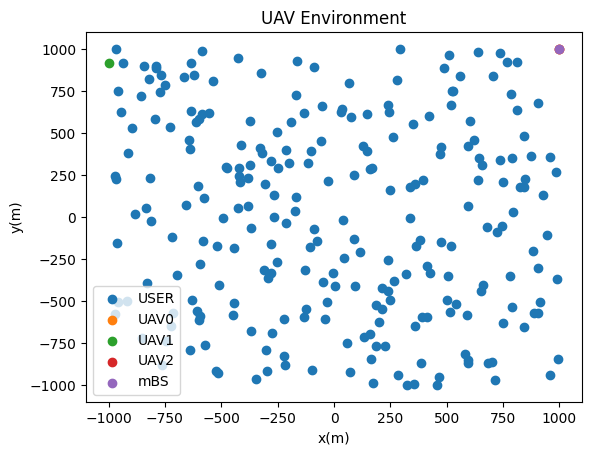

Episode  10 ==================
 Episode 10, The number of satisfied users : 124 


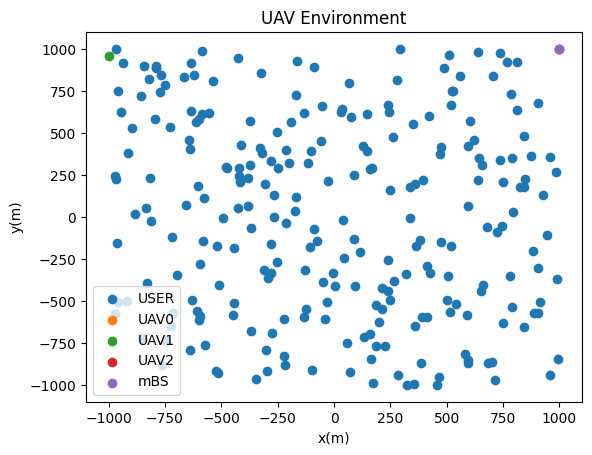

Episode  11 ==================
 Episode 11, The number of satisfied users : 123 


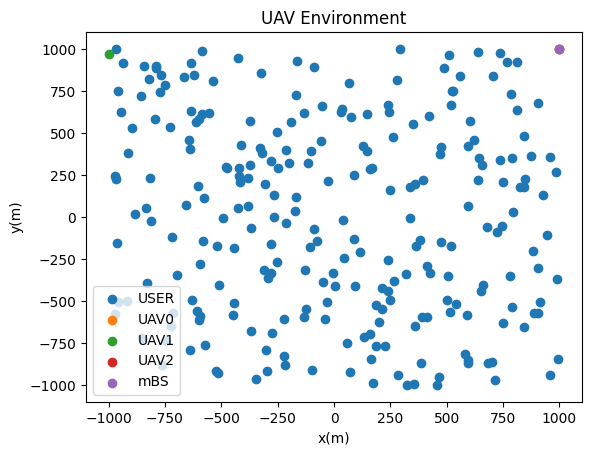

Episode  12 ==================


KeyboardInterrupt: 

In [28]:
scores = reinforce (
        policy0 ,
        optimizer ,
        # optimizer0 ,
        policy1 ,
        # optimizer1 ,
        policy2 ,
        # optimizer2 ,
        n_training_episodes ,
        max_steps ,
        gamma ,
        print_every = 100)